<center>

Multiplicação de Matrizes - GPU vs CPU
===
# Trabalho 4

Autor: Wesley Nogueira Galvão 757665

</center>

Este experimento consiste em usar estratégia de paralelização utilizando GPU para a tarefa de multiplicação de matrizes. Por fim, há uma comparação do desempenho de tempo de execução da mesma tarefa entre GPU e CPU quando submetidos a variados tamanhos de matrizes. 

# Informações do Sistema


Algumas informações do sistema que são relevantes para a avaliação de desempenho. 


In [55]:
# Operational System Info
! lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [2]:
# CPU Info
! lscpu | grep  'Model name\|^CPU(s)\|L3 cache\|Architecture' 

Architecture:        x86_64
CPU(s):              2
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
L3 cache:            56320K


In [3]:
!nvidia-smi

Sat Apr 10 02:02:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# importa macro %%cu
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

# carrega plugin
%load_ext nvcc_plugin

!echo && nvcc --version
!echo && gcc --version
!echo && g++ --version

# Implementação

## Estratégia de divisão de blocos e memória compartilhada

O código aqui experimentado foi adaptado do respositório [lzhengchun /
matrix-cuda ](https://github.com/lzhengchun/matrix-cuda/blob/master/matrix_cuda.cu) para realizar a multiplicação entre duas matrizes de inteiros e quadradas, onde a cada iteração a dimensão das matrizes aumentam. No fim, o código retorna um arquivo CSV para avaliação dos dados.  

A estratégia de particionamento das grades contou com a divisão em partes iguais de colunas e linhas, assim: 


```cpp
    unsigned int grid_rows = (m + BLOCK_SIZE - 1) / BLOCK_SIZE;
    unsigned int grid_cols = (k + BLOCK_SIZE - 1) / BLOCK_SIZE;
    dim3 dimGrid(grid_cols, grid_rows);
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
```

Onde BLOCK_SIZE está definido com tamanho 16. Note que a divisão garante o piso, ou seja, o menor inteiro. 

A função Kernel utiliza o compartilhamento de memória com tiling. Isto é, cada thread acaba carregando dois elementos da entrada A e doi elementos da entrada B, o que totaliza 4 acessos por thread. Isto reduz o acesso à memória global. 


In [30]:
%%writefile matrix_mult_CPU_vs_GPU.cu

#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <math.h>
#include <unistd.h>
#include <sys/types.h>
#include <sys/stat.h>
#include <sys/time.h> 

#define BLOCK_SIZE 16

/*
*********************************************************************
Função kernel que realiza a multiplicação entre duas matrizes quadradas
na GPU. Há o compartilhamento de memória com tiling. Isto é, cada thread
acaba carregando dois elementos da entrada A e doi elementos da entrada B, 
o que totaliza 4 acessos por thread. Isto reduz o acesso à memória global. 

parâmetros: 
    int device_A: Ponteiro dispositivo GPU para a matriz A 
    int device_B: Ponteiro dispositivo GPU para a matriz B
    int device_result: Ponteiro dispositivo GPU para a matriz C, que 
        armazena o resultado
Observação:
   O tamanho dos blocos e grades são configurados como: 
        dim3 dim_grid((n - 1) / BLOCK_SIZE + 1, (n - 1) / BLOCK_SIZE + 1, 1);
        dim3 dim_block(BLOCK_SIZE, BLOCK_SIZE, 1);

Retorno: vazio
*********************************************************************
*/
__global__ void gpu_square_matrix_mult(int *device_A, int *device_B, int *device_result, int n){
    __shared__ int tile_a[BLOCK_SIZE][BLOCK_SIZE];
    __shared__ int tile_b[BLOCK_SIZE][BLOCK_SIZE];

    int row = blockIdx.y * BLOCK_SIZE + threadIdx.y;
    int col = blockIdx.x * BLOCK_SIZE + threadIdx.x;
    int tmp = 0;
    int idx;

    for (int sub = 0; sub < gridDim.x; ++sub){
        idx = row * n + sub * BLOCK_SIZE + threadIdx.x;
        if(idx >= n*n){
            // n may not divisible by BLOCK_SIZE
            tile_a[threadIdx.y][threadIdx.x] = 0;
        }
        else{
            tile_a[threadIdx.y][threadIdx.x] = device_A[idx];
        }

        idx = (sub * BLOCK_SIZE + threadIdx.y) * n + col;
        if(idx >= n*n){
            tile_b[threadIdx.y][threadIdx.x] = 0;
        }  
        else{
            tile_b[threadIdx.y][threadIdx.x] = device_B[idx];
        }

        // Garante a sincronização das threads na execução pela GPU
        __syncthreads();

        for (int k = 0; k < BLOCK_SIZE; ++k){
            tmp += tile_a[threadIdx.y][k] * tile_b[k][threadIdx.x];
        }
        __syncthreads();
    }
    if(row < n && col < n){
        device_result[row * n + col] = tmp;
    }
}

/*
*********************************************************************
Função kernel que realiza a multiplicação entre duas matrizes quadradas
na CPU. 

parâmetros: 
    int host_A: Ponteiro para a matriz A 
    int host_B: Ponteiro  para a matriz B
    int host_result: Ponteiro para a matriz C, que 
        armazena o resultado
    int m: dimensão das matrizes
Retorno: vazio
*********************************************************************
*/

void cpu_matrix_mult(int *host_A, int *host_B, int *host_result, int m) {

    int k, n;
    k = n = m; 

    for (int i = 0; i < m; ++i) 
    {
        for (int j = 0; j < k; ++j) 
        {
            int tmp = 0.0;
            for (int h = 0; h < n; ++h){
                tmp += host_A[i * n + h] * host_B[h * k + j];
            }
            host_result[i * k + j] = tmp;
        }
    }
}

/*
*********************************************************************
Função que compara um a um os valores nas matrizes para validar
se o processamento na GPU foi bem sucedido.

parâmetros: 
    int results_cpu: Para matriz C da CPU
    int results_gpu: Para matriz C da GPU
    int m: dimensão das matrizes

Retorno: 
    int all_ok: uma flag de verificação. 1 para verdadeiro, 0 caso
        contrário. 

*********************************************************************
*/
int results_validation(int *results_cpu, int *results_gpu, int m){

    int k = m;

    int all_ok = 1;
    for (int i = 0; i < m; ++i){
        for (int j = 0; j < k; ++j){
            if(results_cpu[i*k + j] != results_gpu[i*k + j]){
                all_ok = 0;
            }
        }
    }

    return all_ok;
}


int main(int argc, char const *argv[])
{
    int dimension,  m, n, k;
    // Lê a dimensão das matrizes quadráticas A e B 
    dimension = atoi(argv[1]);
    //scanf("%d", &dimension);
    
    // Imprime o cabeçalho do documento CSV
    printf("matrix_size, device, elapsed_time(ms), speedup\n");

    /*As matrizes inicializam com tamanho atribuído à variável
    dimension. A cada iteração, a dimensão da matriz cresce em 
    tamanho fixo dimension até o limite de 2500x2500 */
 
    for(int dim = dimension; dim < 2500; dim  = dim + dimension){ 

        /***************************************************
        *                       HOST
        ***************************************************/  

        // Seed fixo para pseudo aleatorização     
        srand(3333);
        
        /*As variáveis das linhas e colunas
        são atualizadas a cada iteração por*/
        m = n = k = dim; 

        // Define as matrizes utilizadas no host 
        // host_C2 armazena o resultado pela operação na CPU. 
        int *host_A, *host_B, *host_C, *host_C2;
        // alocação de memória na GPU
        cudaMallocHost((void **) &host_A, sizeof(int)*m*n);
        cudaMallocHost((void **) &host_B, sizeof(int)*n*k);
        cudaMallocHost((void **) &host_C, sizeof(int)*m*k);
        cudaMallocHost((void **) &host_C2, sizeof(int)*m*k);

        // Inicializa a matriz A com inteiros aleatórios
        for (int i = 0; i < m; ++i) {
            for (int j = 0; j < n; ++j) {
                host_A[i * n + j] = rand() % 1024;
            }
        }

        // Inicializa a matriz B com inteiros aleatórios
        for (int i = 0; i < n; ++i) {
            for (int j = 0; j < k; ++j) {
                host_B[i * k + j] = rand() % 1024;
            }
        }

        // Define variáveis para armazenar o tempo de execução
        float gpu_elapsed_time_ms, cpu_elapsed_time_ms;

        // some events to count the execution time
        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);

        // Inicia a contagem de tempo de execução da GPU
        cudaEventRecord(start, 0);

        /***************************************************
        *                    GPU DEVICE
        ***************************************************/ 

        // Define e aloca as matrizes utilizadas no device 
        int *device_A, *device_B, *device_C;
        cudaMalloc((void **) &device_A, sizeof(int)*m*n);
        cudaMalloc((void **) &device_B, sizeof(int)*n*k);
        cudaMalloc((void **) &device_C, sizeof(int)*m*k);

        // Copia as matrizes A e B do host para o dispositivo 
        cudaMemcpy(device_A, host_A, sizeof(int)*m*n, cudaMemcpyHostToDevice);
        cudaMemcpy(device_B, host_B, sizeof(int)*n*k, cudaMemcpyHostToDevice);

        /*
            Define o tamanho das grades para linhas e colunas (# blocos), 
            dividindo igualmente essas dimensões pelo fator BLOCK_SIZE .
        */
        unsigned int grid_rows = (m + BLOCK_SIZE - 1) / BLOCK_SIZE;
        unsigned int grid_cols = (k + BLOCK_SIZE - 1) / BLOCK_SIZE;
        dim3 dimGrid(grid_cols, grid_rows);
        dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    
        /*
            Faz a chamada do Kernel gpu_square_matrix_mult<< #blocos, #threads >>
            passando as duas matrizes A e B copiadas para o dispositivo, a matriz
            de resultado C e o tamanho n. 
        */

        gpu_square_matrix_mult<<<dimGrid, dimBlock>>>(device_A, device_B, device_C, n);    
        
        /***************************************************
        *                       HOST
        ***************************************************/  

        // Transfere o resultado processado no Dispositivo para o Host. 
        cudaMemcpy(host_C, device_C, sizeof(int)*m*k, cudaMemcpyDeviceToHost);
        // Garante a sincronização das threads
        cudaThreadSynchronize();

        // Finaliza a contagem de tempo de execução da GPU
        cudaEventRecord(stop, 0);
        cudaEventSynchronize(stop);
        // Calcula o tempo de execução da GPU em milissegundos 
        cudaEventElapsedTime(&gpu_elapsed_time_ms, start, stop);
       

        // Finaliza a contagem de tempo de execução da CPU
        cudaEventRecord(start, 0);
        // Chama pela função de multiplicação de matrizes na CPU
        cpu_matrix_mult(host_A, host_B, host_C2, m);
        // Finaliza a contagem de tempo de execução da CPU
        cudaEventRecord(stop, 0);
        cudaEventSynchronize(stop);
        // Calcula o tempo de execução da CPU em milissegundos 
        cudaEventElapsedTime(&cpu_elapsed_time_ms, start, stop);

        // Chama pela função de validação dos resultados
        int all_ok = results_validation(host_C2, host_C, n);

        // Calcula o speedup
        float speedup = cpu_elapsed_time_ms/gpu_elapsed_time_ms;

        // Se a validação for verdadeira, imprime os resultados
        // formatados para CSV. 
        if(all_ok){   
            printf("%d,CPU,%.3f,%.3f\n", dim, cpu_elapsed_time_ms,speedup);
            printf("%d,GPU,%.3f,%.3f\n", dim, gpu_elapsed_time_ms,speedup);          

        }
        else{
            printf("Resultados incorretos !!\n");
        }

        // Libera os espaços alocados na memória
        cudaFree(device_A);
        cudaFree(device_B);
        cudaFree(device_C);
        cudaFreeHost(host_A);
        cudaFreeHost(host_B);
        cudaFreeHost(host_C);
        cudaFreeHost(host_C2);
    }

    return 0;
}

Overwriting matrix_mult_CPU_vs_GPU.cu


# Avaliação

O comando para compilação é :

```
gcc matriz_multi_paralelo.c -o mmp -lm -fopenmp
```


Para execução, fez-se :
```
./matrix_cpu_gpu [dimensao_matriz_quadrada] >> results.csv
```
O resultado da execução contento as informações da dimensão matricial, dispositivo, seja CPU ou GPU, e seu respectivo tempo de execução, foi exportado para um arquivo CSV. Os dados serão avaliados em seguida. 

In [ ]:
!nvcc matrix_mult_CPU_vs_GPU.cu -o matrix_cpu_gpu && ./matrix_cpu_gpu 100 >> results.csv

Seguindo, há a importação dos dados e sua avaliação gráfica. 

In [16]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [27]:
# Importa como dataframe os resultados do arquivo results.csv
results = pd.read_csv('results.csv')
results.head(15)

,matrix_size,device,elapsed_time(ms),speedup
0,100,CPU,3.813,15.033
1,100,GPU,0.254,15.033
2,200,CPU,27.635,116.797
3,200,GPU,0.237,116.797
4,300,CPU,107.349,306.025
5,300,GPU,0.351,306.025
6,400,CPU,249.082,486.215
7,400,GPU,0.512,486.215
8,500,CPU,542.270,732.480
9,500,GPU,0.740,732.480


In [43]:
# Captura os subsets por device
cpu = results[results['device']=='CPU']
gpu = results[results['device']=='GPU']

No gráfico abaixo, verifica-se o crescimento acelerado da curva de tempo de execução para a CPU, atingindo a ordem de 140000 ms com as matrizes de 2500x2500, contra aproximadamente 30ms para a GPU. 

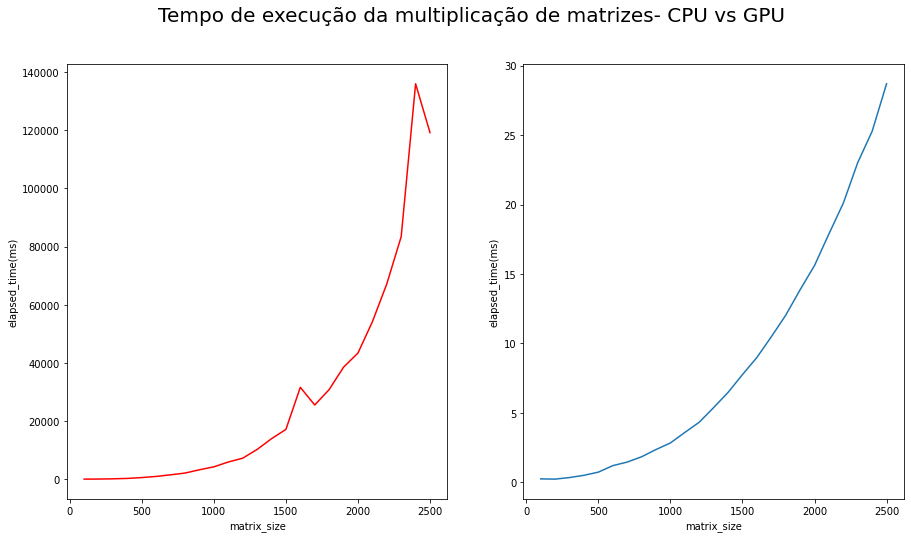

In [41]:
# Comparação entre a curva de tempo de execução
f, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True) # Configura 2 subplots 
f.suptitle('Tempo de execução da multiplicação de matrizes- CPU vs GPU', fontsize=20)

sns.lineplot(data = cpu, x = "matrix_size", y = "elapsed_time(ms)",  
             markers=True, dashes=False, ax = axes[0], color = 'red')

sns.lineplot(data = gpu, x = "matrix_size", y = "elapsed_time(ms)",  
             markers=True, dashes=False, ax = axes[1])

Agora, olhando para o speedup, chega a atingir o pico próximo a 6000. 

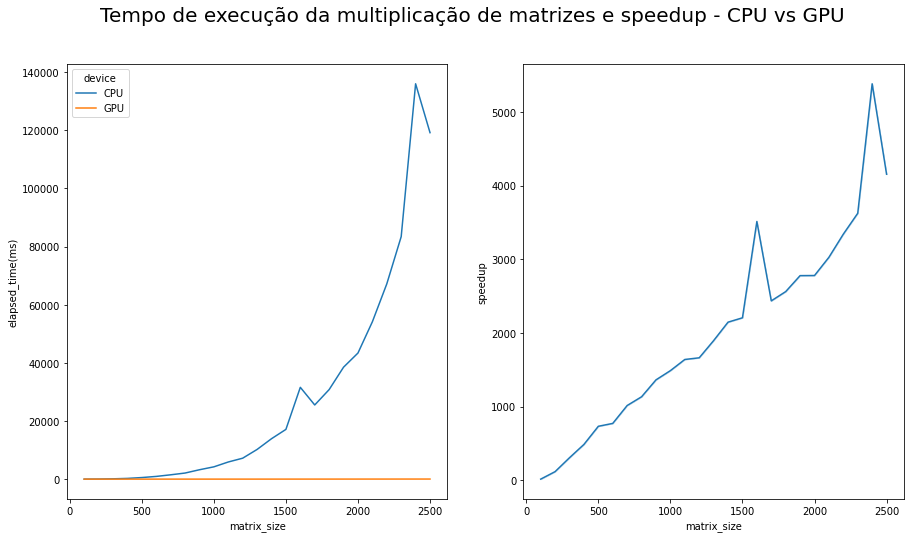

In [42]:
# Comparação entre a curva de tempo de execução e speedup
f, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True) # Configura 2 subplots 
f.suptitle('Tempo de execução da multiplicação de matrizes e speedup - CPU vs GPU', fontsize=20)

sns.lineplot(data = results, x = "matrix_size", y = "elapsed_time(ms)",  
             markers=True, dashes=False, ax = axes[0], hue = 'device')

sns.lineplot(data = results, x = "matrix_size", y = "speedup",  
             markers=True, dashes=False, ax = axes[1])


Por último, na última iteração, onde as matrizes são 2500X2500, o speedup da GPU em relação a CPU é da ordem de 4000X mais rápido. 

In [29]:
# Última iteração
results.tail(2)

,matrix_size,device,elapsed_time(ms),speedup
48,2500,CPU,119210.250,4154.682
49,2500,GPU,28.693,4154.682
